# Poker Cards

In association with [Astraeus-](https://github.com/Astraeus-)

## Packages we need

List of packages we need

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# we use Scikit-Learn for creating the training and test sets, and for computing the class weights
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# we also use Scikit-Learn for computing and displaying the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Read in the dataset

First, we read in the Poker cards dataset. As we can see, we have a lot of hands, over 1 million data.

In [2]:
df_training = pd.read_csv('poker_hands.csv', sep=',', header=0)
df_training

,suit1,suit2,suit3,suit4,suit5,rank1,rank2,rank3,rank4,rank5,ranking
0,hearts,hearts,clubs,clubs,hearts,1,13,4,3,12,nothing
1,diamonds,diamonds,diamonds,spades,clubs,12,2,11,5,5,one_pair
2,hearts,spades,hearts,diamonds,diamonds,9,6,4,2,9,one_pair
3,hearts,diamonds,clubs,clubs,diamonds,4,13,13,1,6,one_pair
4,diamonds,clubs,hearts,clubs,spades,10,7,2,11,9,nothing
...,...,...,...,...,...,...,...,...,...,...,...
1025005,diamonds,clubs,spades,spades,clubs,9,6,11,12,4,nothing
1025006,spades,spades,diamonds,diamonds,hearts,1,10,13,4,10,one_pair
1025007,clubs,clubs,spades,spades,spades,1,10,4,1,13,one_pair
1025008,clubs,spades,hearts,hearts,spades,12,3,10,12,9,one_pair


### Inspect the combinations

We now see how many cards we have per hand. We have a lot of `nothing`, `one_pair` hands. On the other hand, compared to these hands, we have barely any `straight_flush` or `royal_flush` hands. This means that our dataset is very unbalanced. 

In [3]:
print(df_training['ranking'].value_counts())

ranking
nothing            513702
one_pair           433097
two_pairs           48828
three_of_a_kind     21634
straight             3978
flush                2050
full_house           1460
four_of_a_kind        236
straight_flush         17
royal_flush             8
Name: count, dtype: int64


## Balance the dataset

As we have concluded, our dataset per label is very unbalanced. To get good results with our neural network, we first must balance our dataset.

### Undersampling

We first undersample our dataset as suggested by an article written by Prince Ganuma ([reference](https://neptune.ai/blog/how-to-deal-with-imbalanced-classification-and-regression-data)). As he mentioned, this could be dangerous as we loose valuable data which can result in a bad model. An other danger is that the model could be biased towards the majority class. However, we believe undersampling is the best option for our dataset as we have a lot of data (half a million hands) for our majority classes. And meanwhile, we have barely any data for our minority classes.

We have this decided to undersample our top four hands:
- nothing
- one pair
- two paira
- three of a kind

We aimed to keep more nothing hands, so the model still has a bit of an imbalance towards the nothing hands as we want to give class weights later on to these labels. For the nothing hand, we want to have the smallest weight. We gave the same weight to the one pair, two pair and three of a kind hands. We have decided to give the same weight to these hands as they are all hands with pairs. We want to give these hands a bit more weight than the nothing hands as they are more valuable than the nothing hands.

In [4]:
nothing_hand_to_keep            = 4500
one_pair_hand_to_keep           = 4000
two_pairs_hand_to_keep          = 4000
three_of_a_kind_hand_to_keep    = 4000

df_training = df_training.drop(df_training[df_training['ranking'] == 'nothing'].index[nothing_hand_to_keep:])
df_training = df_training.drop(df_training[df_training['ranking'] == 'one_pair'].index[one_pair_hand_to_keep:])
df_training = df_training.drop(df_training[df_training['ranking'] == 'two_pairs'].index[two_pairs_hand_to_keep:])
df_training = df_training.drop(df_training[df_training['ranking'] == 'three_of_a_kind'].index[three_of_a_kind_hand_to_keep:])

print(df_training['ranking'].value_counts())

ranking
nothing            4500
one_pair           4000
two_pairs          4000
three_of_a_kind    4000
straight           3978
flush              2050
full_house         1460
four_of_a_kind      236
straight_flush       17
royal_flush           8
Name: count, dtype: int64


### Oversampling

Even after undersampling, we still have a massive imbalance in our dataset. Now that we have around 4k hands on our majority classes, we sill have a tiny, 8 hands on our minority classes. We could, of course, do even more undersampling, but we believe that we would loose too much data. Therefore, we have decided to oversample our minority classes as suggested by an article written by Jason Brownlee ([reference](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)).

With oversampling there is one big danger. We could overfit our model. With oversampling, we would duplicate our minority classes. This means that we would have the same data in our training and validation set. So, our accuracy would be very high, but our model would not be able to generalize. We could also artificially generate new data, but we believe that this would not be part of "preprocessing" and it would be part of the data collection process. In that case we could also just use a different dataset we find online. We want to work with the dataset we have now, so we have decided to duplicate our minority classes.

With duplication, we must be aware of the following limitations:

- The same data will be both in training and testing, so the model will not be able to generalize.
- The model might be biased towards the minority classes as it will see more of these classes.

We decided to oversample the following minority classes:

- royal flush (as it only has 8 samples)
- straight flus (as it only has 17 samples)
- four of a kind (as it only has 236 samples)

We will oversample these hands to the median of all classes and we make the balancing dependent on the original class count. This way we still have a bit of an imbalance towards the majority classes to indicate that these hands are more common.

In [5]:
median_items = int(df_training['ranking'].value_counts().median())

hands_to_balance = ['royal_flush', 'straight_flush', 'four_of_a_kind']

print(f'median_items: {median_items}')

df_training_oversampled = df_training.copy()

for class_number, class_count in df_training['ranking'].value_counts().items():
    if class_number not in hands_to_balance:
        continue
    df_class = df_training[df_training['ranking'] == class_number]
    df_training_oversampled = pd.concat([df_training_oversampled, df_class.sample(median_items - class_count, replace=True)])


df_training = df_training_oversampled

print(df_training['ranking'].value_counts())

median_items: 3014
ranking
nothing            4500
one_pair           4000
two_pairs          4000
three_of_a_kind    4000
straight           3978
four_of_a_kind     3014
straight_flush     3014
royal_flush        3014
flush              2050
full_house         1460
Name: count, dtype: int64


## Preprocess the data

We must now one-hot encode the cards with enumerated values (the suits). This is needed so we have a numerical representation of the cards. We also need to convert every numerical value to a float. This is needed so we can feed the data to TensorFlow, as tensors work best with floats.

We then encode our labels with a custom encoder to numerical values.

In [6]:
df_suits = pd.get_dummies(df_training[['suit1', 'suit2', 'suit3', 'suit4', 'suit5']], prefix='suit')

df_training_encoded = pd.concat([df_training, df_suits], axis=1)

df_training_encoded = df_training_encoded.drop(['suit1', 'suit2', 'suit3', 'suit4', 'suit5'], axis=1)

# Map hand rankings to numerical values
label_encoder = {'nothing': 0, 'one_pair': 1, 'two_pairs': 2, 'three_of_a_kind': 3, 'straight': 4, 'flush': 5, 'full_house': 6, 'four_of_a_kind': 7, 'straight_flush': 8, 'royal_flush': 9}
df_training_encoded['ranking'] = df_training_encoded['ranking'].map(label_encoder)

# convert ranks to float 32
df_training_encoded = df_training_encoded.astype('float32')

df_training_encoded

,rank1,rank2,rank3,rank4,rank5,ranking,suit_clubs,suit_diamonds,suit_hearts,suit_spades,...,suit_hearts,suit_spades,suit_clubs,suit_diamonds,suit_hearts,suit_spades,suit_clubs,suit_diamonds,suit_hearts,suit_spades
0,1.0,13.0,4.0,3.0,12.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,12.0,2.0,11.0,5.0,5.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,9.0,6.0,4.0,2.0,9.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,13.0,13.0,1.0,6.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10.0,7.0,2.0,11.0,9.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944522,1.0,11.0,10.0,12.0,13.0,9.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
61843,12.0,1.0,13.0,11.0,10.0,9.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
289231,10.0,11.0,13.0,1.0,12.0,9.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
61843,12.0,1.0,13.0,11.0,10.0,9.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Create training and testing datasets

First, we create separate variables for the data `X` and for the labels `y`. We one-hot encode the labels, so that we can use them in our neural network, since one-hot encoding makes it easier for the neural network to learn the labels.

In [7]:
X = df_training_encoded.drop('ranking', axis=1) # values
y = df_training_encoded['ranking'] # labels
y_one_hot = tf.keras.utils.to_categorical(y)

### Split the data and compute class weights

We split our data into 10% testing data and 90% training data. We have a lot of data, so we can afford to use 10% of our data for testing. We use the random state of `42` to make sure that we always get the same split.

We also give `y` to stratify, so that we get the same distribution of labels in our training and testing data. This is important, because we have a very unbalanced dataset.

Finally, we compute the class weights for our labels. We use these weights in our neural network, so that the neural network can get a true accuracy. Guessing constantly the `nothing` hand of which we have a lot, would give us a high accuracy, but it would not be a true indicator of the performance of our neural network.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.1, random_state = 42, stratify=y)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 0.734,
 1: 0.82575,
 2: 0.82575,
 3: 0.82575,
 4: 0.830316742081448,
 5: 1.611219512195122,
 6: 2.2623287671232877,
 7: 1.0958858659588586,
 8: 1.0958858659588586,
 9: 1.0958858659588586}

### Computed class weights evaluation

From the dictionary above we can see the different class weights. If the neural network guesses a label with a high weight, it will be rewarded more than if it guesses a label with a low weight. This is because we want the neural network to guess the labels with a high weight more often, since we have less data of these labels.

In [9]:
train_sets = y_train.sum(axis=0)
test_sets = y_test.sum(axis=0)

label_sets = {v: k for k, v in label_encoder.items()}
print('Training set:')
for i in range(len(train_sets)):
    print(f'\t - {label_sets[i]}: {int(train_sets[i])}')
print('\nTesting set:')
for i in range(len(test_sets)):
    print(f'\t - {label_sets[i]}: {int(test_sets[i])}')


Training set:
	 - nothing: 4050
	 - one_pair: 3600
	 - two_pairs: 3600
	 - three_of_a_kind: 3600
	 - straight: 3580
	 - flush: 1845
	 - full_house: 1314
	 - four_of_a_kind: 2713
	 - straight_flush: 2713
	 - royal_flush: 2712

Testing set:
	 - nothing: 450
	 - one_pair: 400
	 - two_pairs: 400
	 - three_of_a_kind: 400
	 - straight: 398
	 - flush: 205
	 - full_house: 146
	 - four_of_a_kind: 301
	 - straight_flush: 301
	 - royal_flush: 302


## Models

To create replicable results models that is easy to configure for experimentation, we have created a `NeuralNetwork` class as a wrapper.

We used the following defaults for our base model:
- Adam optimizer with a learning rate of 3e-4 (as suggested by [Andrej Karpathy](https://karpathy.ai) in a [tweet](https://twitter.com/karpathy/status/801621764144971776?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E801621764144971776%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fbrandonlmorris.github.io%2F2018%2F06%2F24%2Fmastering-the-learning-rate%2F))
- No regularization
- An input layer with the shape of the input data
- After the input layer a normalization layer to put our data to the same scale allowing us to use larger learning rates or help models converge faster for a given learning rate (as suggested by an [article](https://machinelearningmastery.com/using-normalization-layers-to-improve-deep-learning-models/#:~:text=Normalization%20can%20help%20training%20of,for%20a%20given%20learning%20rate.) by Jason Brownlee)
- We se softmax as our activation function for our output layer because we have a multi-class classification problem
- We use categorical crossentropy as our loss function as we have a multi-class classification problem
- For our metrics we use accuracy.
- We train our model using a batch size of 32 (the default)
- We use validation split of 0.2 to hold back 20% of our training data for validation

For all of our models, we will keep the same following settings, so that we can compare the models with each other:
- We will train our models for 30 epochs as we have noticed during initial testing that the models converge after 20-30 epochs
- We use an early stopping of 5 epochs to prevent overfitting

### Explaining our use of Batch Normalization

In our model, we offer the option to use `Batch Normalization`. Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch, meaning that inputs will have a mean of zero and a standard deviation of one. ([article](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/) by  Jason Brownlee) This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks. Upon completion of training, the average and deviation metrics within the layer will be employed to normalize inputs during the model's predictive phase.

The batch normalization layer can be placed to various places:

- At the input layer
- After the activation function of a hidden layer
- Before the activation function of a hidden layer

Batch layer *could* be used as a preprocessing technique when used for the input layer, but should be avoided. Thus, we didn't use it so. The [original paper](https://arxiv.org/abs/1502.03167) suggested to use batch normalization before the activation function, however some [performance tests](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) have shown that using it after the activation function is better. So, we decided to use it after the activation function, so the next layer will receive normalized inputs. In general, the are lots of debate where to put batch normalization.

### Regularization

Regularization, employed in machine learning and deep learning, aims to mitigate overfitting and enhance a model's generalization capabilities. It achieves this by introducing a penalty term to the loss function during training, discouraging excessive complexity and large parameter values. By doing so, regularization controls the model's tendency to fit noise in training data. ([article](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) by Shubham Jain). 

There are two common regularization techniques:

- L1 regularization
- L2 regularization

They both update the general cost function by adding another term known as the regularization term.

We concluded the differences in the table below.

| L1 Regularization | L2 Regularization |
|-------------------|-------------------|
| The outcome of L1 regularization results in sparsity. | The L2 regularization solution is non-sparse. |
| Has built-in feature selection | Does not have built-in feature selection |
| More robust | Less robust |
| There are many routes that can be taken to arrive at a point | There is only one route that can be taken to arrive at a point |
| Computationally more expensive | Computationally less expensive |

(Table concluded from an [article](https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization#:~:text=The%20differences%20between%20L1%20and,L1%20regularization%20solution%20is%20sparse.) by Kurtis Pykes)

This means, that L2 is better in general than L1 in terms of accuracy and adjusting the weights. Alternatively, L1 regularization can manage sparse feature sets and facilitate feature selection. Thus, integrating L2 and L1 provides both accuracy and sparsity. ([Quora post](https://www.quora.com/What-is-the-advantage-of-combining-L2-and-L1-regularizations) by Xavier Amatriain)

In [39]:
class NeuralNetwork:
    def __init__(self, layer_config, name, optimizer=tf.optimizers.legacy.Adam(learning_rate=3e-4), regularizer=None, model=None):
        self.layer_config = layer_config # list of dense layers
        self.root_logdir = "logs/as1/models/" # root directory for TensorBoard logs
        self.root_modeldir = "models/as1/" # root directory for saving models
        self.model_name = name # name of the model for saving
        self.model = model # the model itself
        self.optimizer = optimizer
        self.regularizer = regularizer
    
    def compile(self):
        model = tf.keras.models.Sequential()

        model.add(tf.keras.Input(shape=(len(X.columns),)))  # input layer

        normalizer = tf.keras.layers.Normalization()
        normalizer.adapt(X)
        model.add(normalizer) # normalization layer

        for l in self.layer_config: # add hidden layers
            model.add(tf.keras.layers.Dense(
                units=l['size'],
                activation=l['activation'],
                use_bias=l['use_bias'],
                kernel_regularizer=self.regularizer,
                bias_regularizer=self.regularizer,
                activity_regularizer=self.regularizer
            ))  # hidden layers
            # batch normalization if specified
            if 'batch_norm' in l and l['batch_norm']:
                model.add(tf.keras.layers.BatchNormalization())
            if 'dropout' in l: # dropout if specified
                model.add(tf.keras.layers.Dropout(l['dropout']))  # dropout layers
        model.add(tf.keras.layers.Dense(len(label_encoder), activation='softmax'))  # output layer

        model.compile(
            optimizer=self.optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model = model # save model
    
    def fit(self, X_train, y_train, X_test, y_test, epochs=10, validation_split=0.2, weights=None, verbose=0, early_stopping_patience=None):
        print(f"Training {self.model_name}...")
        if self.model is None:
            self.compile() # compile model if not already compiled
        
        logdir = self.root_logdir + "temp/" + datetime.now().strftime("%Y%m%d-%H%M%S") # create log directory
        
        callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir)] # create TensorBoard callback

        # Add EarlyStopping callback if early_stopping_patience is specified
        if early_stopping_patience:
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='accuracy', # stop when accuracy stops improving
                patience=early_stopping_patience,
                restore_best_weights=True
            )
            callbacks.append(early_stopping)

        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=validation_split,
            validation_data=(X_test, y_test), # use test set for validation
            class_weight=weights,
            verbose=verbose,
            # batch_size=256 * 2
        )

        # save model
        self.model.save(self.root_modeldir + self.model_name + '.keras')
        # save history
        df_history = pd.DataFrame(history.history)
        df_history.to_csv(self.root_logdir + self.model_name + '.csv')
        print(f"Training {self.model_name} complete.")

    def evaluate(self, X_test, y_test, X_train, y_train):
        # load model
        self.model = tf.keras.models.load_model(self.root_modeldir + self.model_name + '.keras')
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        train_loss, train_accuracy = self.model.evaluate(X_train, y_train, verbose=0)

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

        # read history
        history = pd.read_csv(self.root_logdir + self.model_name + '.csv')

        # Plot training and test history in a single chart with subplots
        plt.figure(figsize=(12, 6))

        # Plot Training Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy', color='orange')
        plt.plot(history['val_accuracy'], label='Test Accuracy', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Test Accuracy over Epochs')

        # Plot Training Loss
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss', color='orange')
        plt.plot(history['val_loss'], label='Test Loss', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Test Loss over Epochs')

        # Title and Show
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(self.model.predict(X_test, verbose=0), axis=1))
        ConfusionMatrixDisplay(cm, display_labels=label_encoder.values()).plot(cmap=plt.cm.Blues) 

    def predict(self, file_path):
        """
        This function takes a file path to a CSV file containing test poker hands and prints the prediction accuracy
        """
        dataset = pd.read_csv(file_path, sep=',', header=0)
        df_suits = pd.get_dummies(dataset[['suit1', 'suit2', 'suit3', 'suit4', 'suit5']], prefix='suit')
        df_training_encoded = pd.concat([dataset, df_suits], axis=1)
        df_training_encoded = df_training_encoded.drop(['suit1', 'suit2', 'suit3', 'suit4', 'suit5'], axis=1)
        label_encoder = {'nothing': 0, 'one_pair': 1, 'two_pairs': 2, 'three_of_a_kind': 3, 'straight': 4, 'flush': 5, 'full_house': 6, 'four_of_a_kind': 7, 'straight_flush': 8, 'royal_flush': 9}
        df_training_encoded['ranking'] = df_training_encoded['ranking'].map(label_encoder)
        df_training_encoded = df_training_encoded.astype('float32')
        y = df_training_encoded['ranking'] # labels
        y_one_hot = tf.keras.utils.to_categorical(y)
        y_test = y_one_hot
        X_test = df_training_encoded.drop('ranking', axis=1)
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

### 1. First model - Initial model

For our first model, we create a small neural network with overfitting in mind. We make 3 hidden layers with 50 neurons each.

To avoid overfitting, we use dropout layers after each hidden layer. We use a dropout rate of 0.2. We also use bias, so that the model can learn the bias of the data.

We also use batch normalization after each hidden layer's activation function. We we do not use any normalization layer.

In [11]:
layers_1 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_1 = NeuralNetwork(layers_1, 'model_1')

In [12]:
model_1.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_1...
Epoch 1/30
929/929 [==============================] - 2s 1ms/step - loss: 2.4264 - accuracy: 0.1650 - val_loss: 1.8576 - val_accuracy: 0.2767
Epoch 2/30
929/929 [==============================] - 1s 1ms/step - loss: 1.9455 - accuracy: 0.2347 - val_loss: 1.6922 - val_accuracy: 0.3061
Epoch 3/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7783 - accuracy: 0.2601 - val_loss: 1.6311 - val_accuracy: 0.3140
Epoch 4/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6941 - accuracy: 0.2805 - val_loss: 1.5820 - val_accuracy: 0.3454
Epoch 5/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6275 - accuracy: 0.3009 - val_loss: 1.5462 - val_accuracy: 0.3569
Epoch 6/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5868 - accuracy: 0.3161 - val_loss: 1.5181 - val_accuracy: 0.3712
Epoch 7/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5423 - accuracy: 0.3382 - val_loss: 1.4810 - val_acc

#### Evaluation

Using undersampling, oversampling and class weights, we got a rather accurate model of 54% accuracy on small neural network. Both our test and train accuracies are the same, which means that we do not have any overfitting. When looking at the graphs for accuracy and loss, we can see that the training and testing lines are very close to each other, which means that we do not have much overfitting. The slope also shows that the model is continuously learning and flattens out at the end at around the 30th epoch (this is why we use early stopping of 5 epochs and train for 30 epochs).

However, when we look at the confusion matrix, our earlier hypotheses during over- and undersampling are confirmed. We have a lot of false positives for the `nothing` hand. This is because we have a lot of data for this hand and they are all different as we downsampled this hand. We oversampled the last three minority classes (label 7, 8, and 9) with duplicating. We can see that the model was able to learn these labels very well, as we have a lot of true positives for these labels. From the confusion matrix we can clearly tell where the over and undersampling happened.

(**Important to note:** due to oversampling, we have the same data for small labels in our training and testing data, so we cannot confidently say that we do not have overfitting.)

Test Loss: 1.1732, Test Accuracy: 54.47%
Train Loss: 1.1575, Train Accuracy: 54.16%


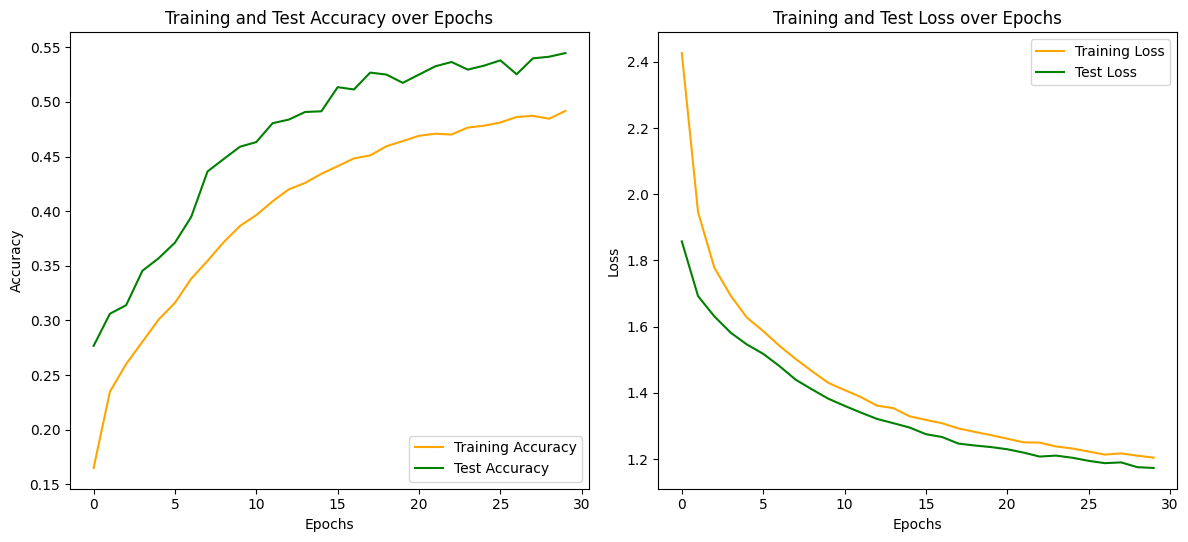

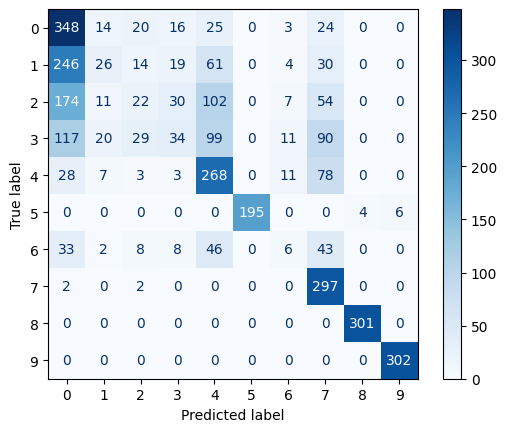

In [13]:
model_1.evaluate(X_test, y_test, X_train, y_train)

### 2. Second model - Bigger Network

For our second model, we create a larger neural network with more neurons in the hidden layers and more hidden layers.

Changes made compared to the first model:

- `size`: from 50 to 100
- `layers`: from 3 to 6

We kept everything else the same. We want to see if with a larger network on the same configuration, we can get better results. for our non-oversampled labels.

In [14]:
layers_2 = [
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_2 = NeuralNetwork(layers_2, 'model_2')

In [15]:
model_2.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_2...
Epoch 1/30
929/929 [==============================] - 3s 2ms/step - loss: 2.0980 - accuracy: 0.1993 - val_loss: 1.6626 - val_accuracy: 0.2858
Epoch 2/30
929/929 [==============================] - 2s 2ms/step - loss: 1.7839 - accuracy: 0.2417 - val_loss: 1.6149 - val_accuracy: 0.3070
Epoch 3/30
929/929 [==============================] - 2s 2ms/step - loss: 1.6906 - accuracy: 0.2669 - val_loss: 1.5887 - val_accuracy: 0.3252
Epoch 4/30
929/929 [==============================] - 2s 2ms/step - loss: 1.6325 - accuracy: 0.2870 - val_loss: 1.5532 - val_accuracy: 0.3445
Epoch 5/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5920 - accuracy: 0.3037 - val_loss: 1.5225 - val_accuracy: 0.3473
Epoch 6/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5512 - accuracy: 0.3263 - val_loss: 1.4859 - val_accuracy: 0.3857
Epoch 7/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5121 - accuracy: 0.3474 - val_loss: 1.4417 - val_acc

#### Evaluation

Interestingly, with a significantly larger neural network, our model did not improve much. We only gained 2% more accuracy from 54% to 56%.

Based on our slopes in our line-charts and the percentage differences between the training and testing, we can see that our model is still likely not overfitting. This is likely due to the techniques we use to avoid overfitting, such as dropout layers batch normalization and bias.

From our confusion matrix, however, we can see the same results as before. Our model is still giving us a lot of false positives for our downsampled labels and a lot of true positives for our oversampled labels. This is likely because of the duplication techniques we used for balancing the dataset.

Test Loss: 1.0989, Test Accuracy: 56.13%
Train Loss: 1.0878, Train Accuracy: 56.53%


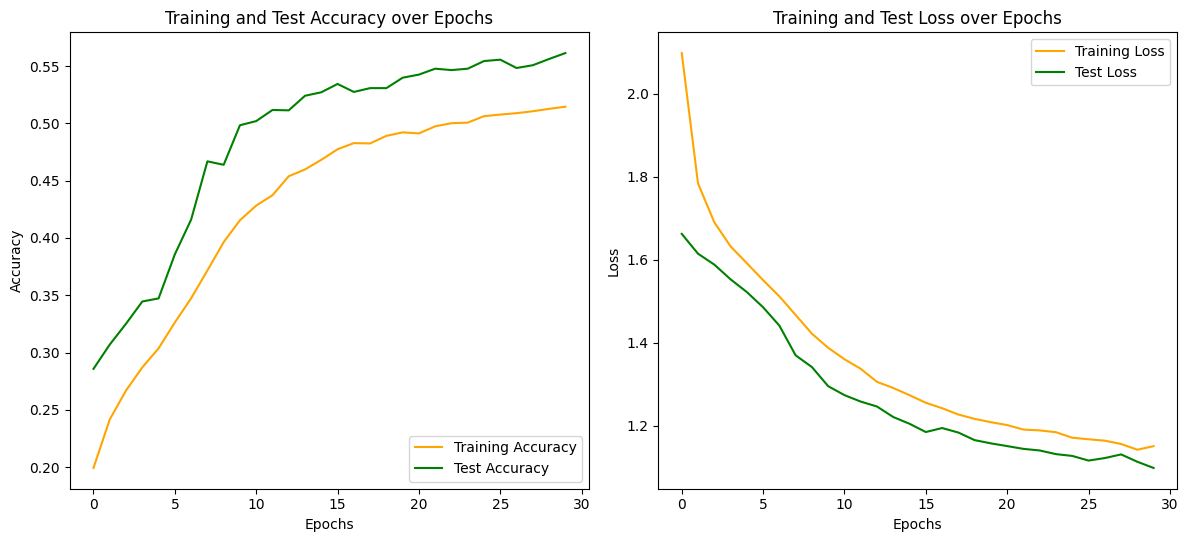

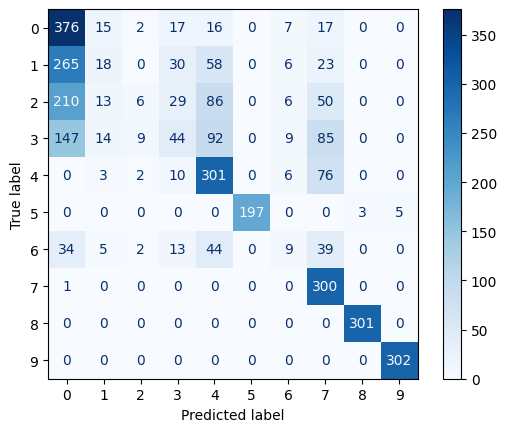

In [16]:
model_2.evaluate(X_test, y_test, X_train, y_train)

### 3. Third model - Tanh

Since we concluded in our 2nd model that a larger network likely will not result in a better model we decided to keep the same network size as in our 1st model. We only changed the activation function.

Changes made compared to the first model:

- `activation`: from `relu` to `tanh`

In [17]:
layers_3 = [
    {'activation': 'tanh', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'tanh', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'tanh', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_3 = NeuralNetwork(layers_3, 'model_3')

In [18]:
model_3.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_3...
Epoch 1/30
929/929 [==============================] - 2s 1ms/step - loss: 2.2240 - accuracy: 0.1917 - val_loss: 1.7880 - val_accuracy: 0.2831
Epoch 2/30
929/929 [==============================] - 1s 1ms/step - loss: 1.8630 - accuracy: 0.2398 - val_loss: 1.6800 - val_accuracy: 0.2931
Epoch 3/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7561 - accuracy: 0.2499 - val_loss: 1.6457 - val_accuracy: 0.3018
Epoch 4/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6881 - accuracy: 0.2660 - val_loss: 1.6227 - val_accuracy: 0.2940
Epoch 5/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6516 - accuracy: 0.2737 - val_loss: 1.5917 - val_accuracy: 0.3209
Epoch 6/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6199 - accuracy: 0.2867 - val_loss: 1.5742 - val_accuracy: 0.3200
Epoch 7/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5925 - accuracy: 0.3005 - val_loss: 1.5452 - val_acc

#### Evaluation

Our overall accuracy decreased from 54% to 49%. This means that `tanh` is not a good activation function for our model. Fortunately, we still see a non-overfitting model based on our line-charts and accuracy differences between training and testing.

Our confusion matrix still shows the same results as in model 1 and 2.

Test Loss: 1.2914, Test Accuracy: 49.59%
Train Loss: 1.2880, Train Accuracy: 49.55%


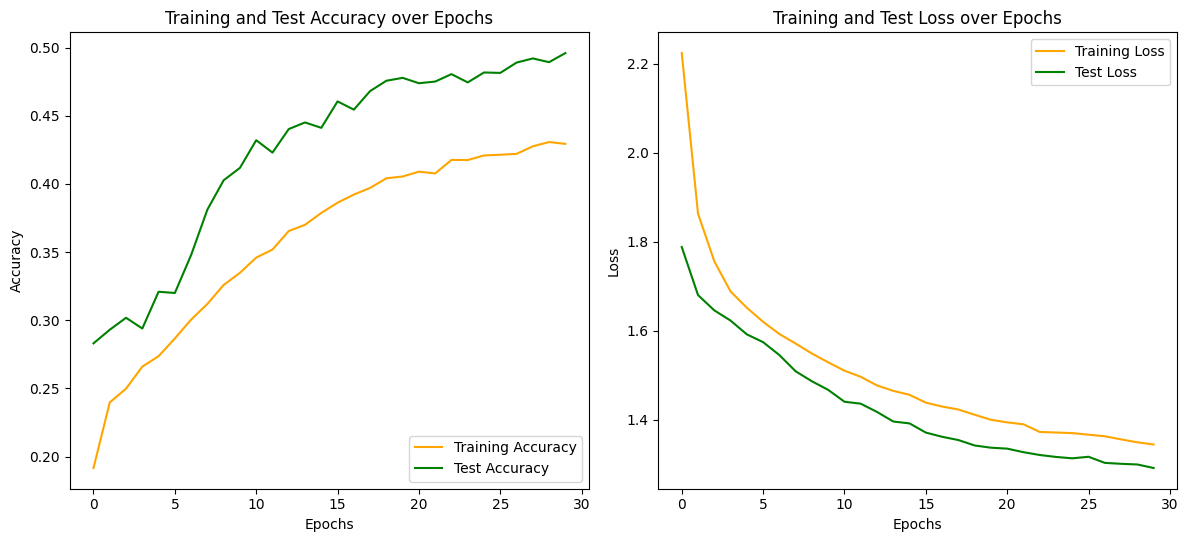

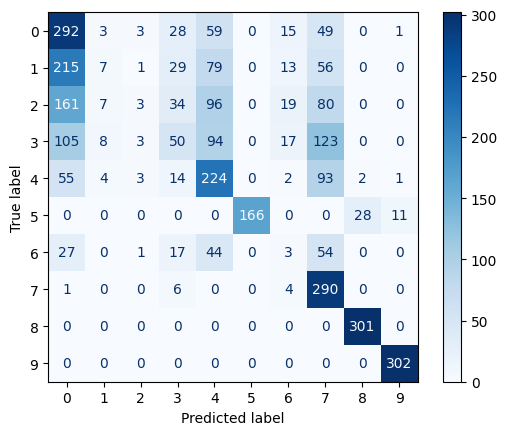

In [19]:
model_3.evaluate(X_test, y_test, X_train, y_train)

### 4. Fourth model - Sigmoid

Now we want to try out a different activation function. We saw that `tanh` did not work well, so we want to try out `sigmoid` instead of `relu`. We keep our model the same size as in model 1.

Changes made compared to the first model:

- `activation`: from `relu` to `sigmoid`

In [20]:
layers_4 = [
    {'activation': 'sigmoid', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'sigmoid', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'sigmoid', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_4 = NeuralNetwork(layers_4, 'model_4')

In [21]:
model_4.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_4...
Epoch 1/30
929/929 [==============================] - 2s 1ms/step - loss: 2.2937 - accuracy: 0.1734 - val_loss: 1.9667 - val_accuracy: 0.2377
Epoch 2/30
929/929 [==============================] - 1s 1ms/step - loss: 1.9910 - accuracy: 0.2124 - val_loss: 1.7603 - val_accuracy: 0.2740
Epoch 3/30
929/929 [==============================] - 1s 1ms/step - loss: 1.8210 - accuracy: 0.2361 - val_loss: 1.6985 - val_accuracy: 0.2555
Epoch 4/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7436 - accuracy: 0.2501 - val_loss: 1.6727 - val_accuracy: 0.2916
Epoch 5/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7052 - accuracy: 0.2608 - val_loss: 1.6392 - val_accuracy: 0.3149
Epoch 6/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6719 - accuracy: 0.2728 - val_loss: 1.6135 - val_accuracy: 0.3309
Epoch 7/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6430 - accuracy: 0.2863 - val_loss: 1.5922 - val_acc

#### Evaluation

We got an even smaller accuracy of 48% than `tanh`. This means that `sigmoid` is not a good activation function for our model. This concludes that `relu` is the best activation function for our model.

For the rest, we see the same results as in model 1, 2 and 3 in terms of overfitting and confusion matrix.

Test Loss: 1.2956, Test Accuracy: 48.68%
Train Loss: 1.2953, Train Accuracy: 48.97%


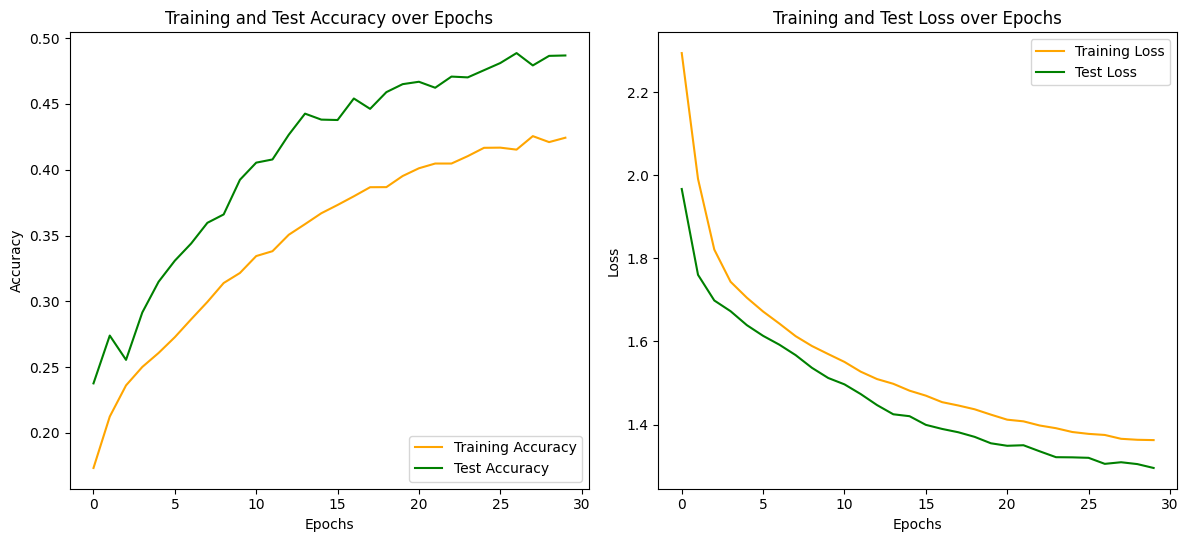

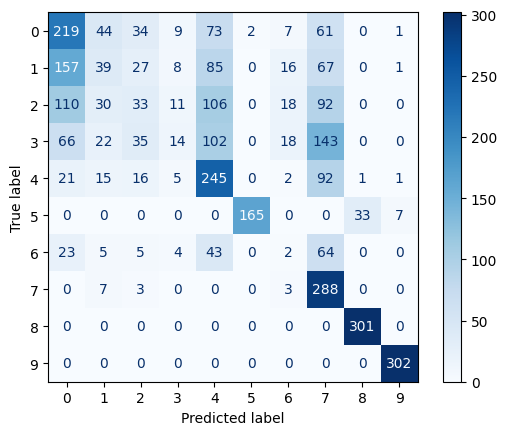

In [22]:
model_4.evaluate(X_test, y_test, X_train, y_train)

### 5. Fifth model - Varied Network Size

Now we want to change the shape and size of our network. We want to see if we can get better results with a different hidden layer size with a varied amount of neurons.

Changes made compared to the first model:

- `layers`: from 3 to 5
- `size`: varied between 50 to 500

We keep the activation function the same as in model 1 as it is the best activation function for our model.

In [25]:
layers_5 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 500, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_5 = NeuralNetwork(layers_5, 'model_5')

In [26]:
model_5.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_5...
Epoch 1/30
929/929 [==============================] - 3s 2ms/step - loss: 2.0621 - accuracy: 0.2225 - val_loss: 1.6523 - val_accuracy: 0.3224
Epoch 2/30
929/929 [==============================] - 2s 2ms/step - loss: 1.7367 - accuracy: 0.2778 - val_loss: 1.5901 - val_accuracy: 0.3524
Epoch 3/30
929/929 [==============================] - 2s 2ms/step - loss: 1.6461 - accuracy: 0.2996 - val_loss: 1.5371 - val_accuracy: 0.3688
Epoch 4/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5870 - accuracy: 0.3229 - val_loss: 1.5193 - val_accuracy: 0.3703
Epoch 5/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5486 - accuracy: 0.3360 - val_loss: 1.4848 - val_accuracy: 0.3878
Epoch 6/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5060 - accuracy: 0.3531 - val_loss: 1.4428 - val_accuracy: 0.4057
Epoch 7/30
929/929 [==============================] - 2s 3ms/step - loss: 1.4701 - accuracy: 0.3689 - val_loss: 1.4245 - val_acc

#### Evaluation

We got a very similar accuracy of 54% as in model 1. This reconfirms our conclusion that the size of the network does not matter much for our model.

For the rest, we see the same results as in model 1, 2, 3 and 4 in terms of overfitting and confusion matrix.

**Remarks:** The reason why we got so similar results could be of three factors:

- Due to our overfitting techniques, the layer size does not matter much for the size of our model
- We did not vary the layer size enough, and we should have increased the layer size even more
- Due to over- and undersampling, we bias our model

Test Loss: 1.1749, Test Accuracy: 53.74%
Train Loss: 1.1574, Train Accuracy: 54.11%


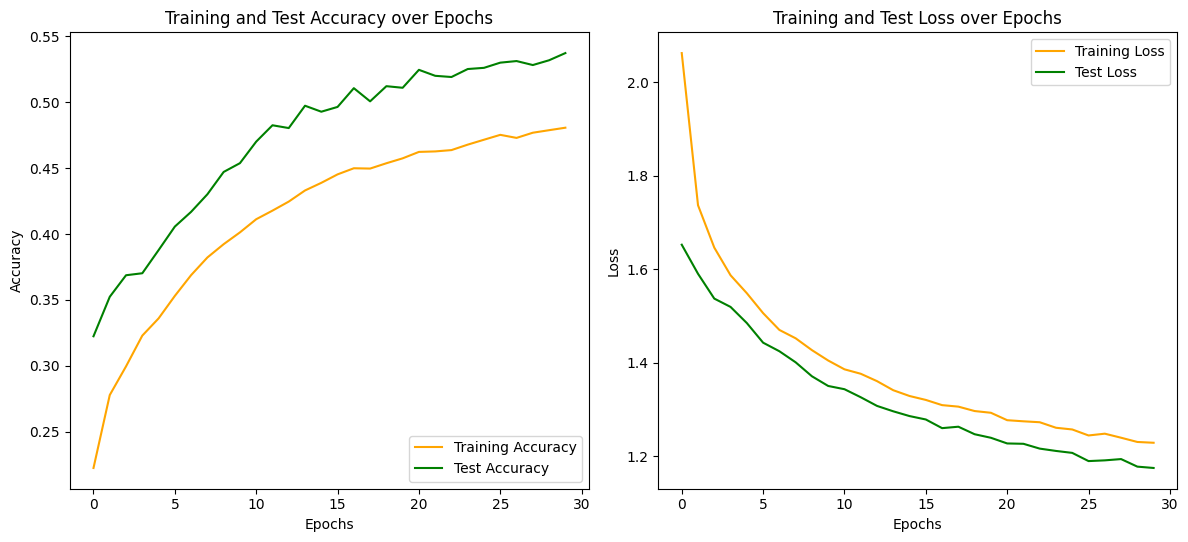

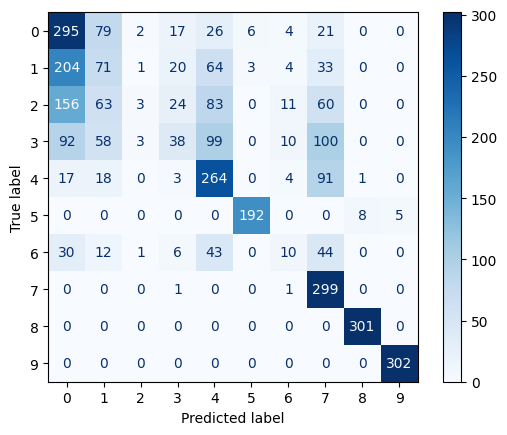

In [27]:
model_5.evaluate(X_test, y_test, X_train, y_train)

### 6. Sixth model - Varied Network Size and Activation

After our 5th model, we decided to redo the experiment but with a varied activation function. We want to see if we can get better results with a different hidden layer size with a varied amount of neurons and a different activation function.

Changes made compared to the first model:

- `layers`: from 3 to 5
- `size`: varied between 50 to 500
- `activation`: varied between `relu`, `tanh` and `sigmoid`

In [28]:
layers_6 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'tanh', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'sigmoid', 'size': 500, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'tanh', 'size': 100, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_6 = NeuralNetwork(layers_6, 'model_6')

In [29]:
model_6.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_6...
Epoch 1/30
929/929 [==============================] - 3s 3ms/step - loss: 1.9674 - accuracy: 0.2424 - val_loss: 1.6096 - val_accuracy: 0.3364
Epoch 2/30
929/929 [==============================] - 2s 2ms/step - loss: 1.6676 - accuracy: 0.2989 - val_loss: 1.5248 - val_accuracy: 0.3666
Epoch 3/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5878 - accuracy: 0.3208 - val_loss: 1.4828 - val_accuracy: 0.3996
Epoch 4/30
929/929 [==============================] - 2s 2ms/step - loss: 1.5287 - accuracy: 0.3374 - val_loss: 1.4518 - val_accuracy: 0.4081
Epoch 5/30
929/929 [==============================] - 2s 2ms/step - loss: 1.4965 - accuracy: 0.3523 - val_loss: 1.4342 - val_accuracy: 0.4148
Epoch 6/30
929/929 [==============================] - 2s 3ms/step - loss: 1.4585 - accuracy: 0.3648 - val_loss: 1.4187 - val_accuracy: 0.4293
Epoch 7/30
929/929 [==============================] - 2s 2ms/step - loss: 1.4414 - accuracy: 0.3736 - val_loss: 1.4042 - val_acc

#### Evaluation

We basically got the same results as in model 1. This reconfirms our conclusion that the size of the network does not matter much for our model. Interestingly, with different activation functions, we got the same results. This is likely because of the fact that it had our best activation function `relu` in the mix.

What we observed is that the accuracies in the chart are less close to each other between training and testing than in model 1. This is likely due to the fact that we varied the activation function.

In general, the different network size, neuron size and mix of activation functions did not improve the model and the confusion matrix still shows the same results as in model 1, 2, 3, 4 and 5.

Test Loss: 1.1767, Test Accuracy: 54.37%
Train Loss: 1.1683, Train Accuracy: 54.39%


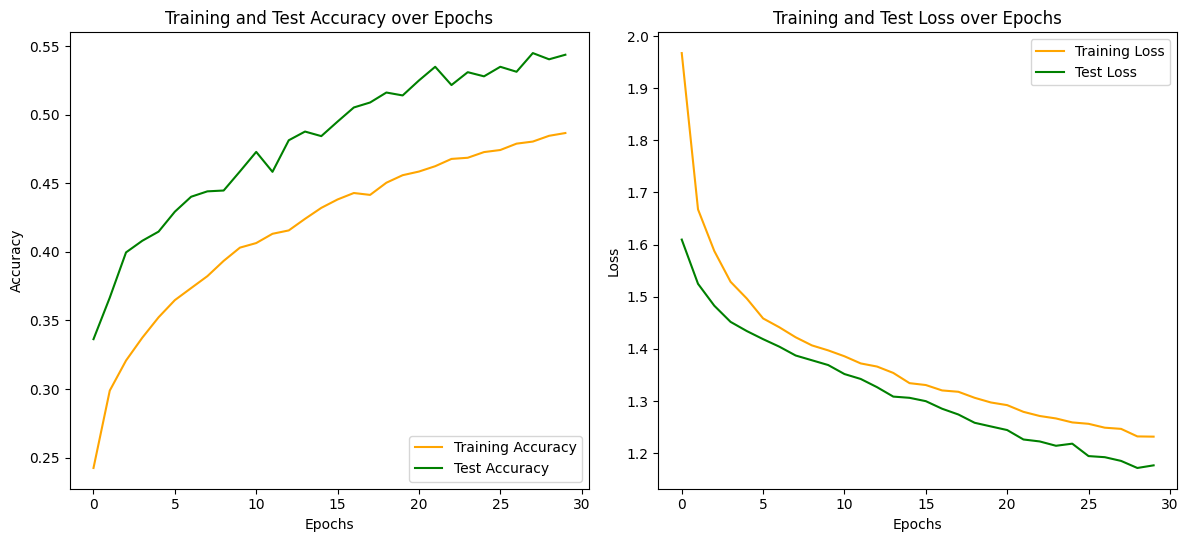

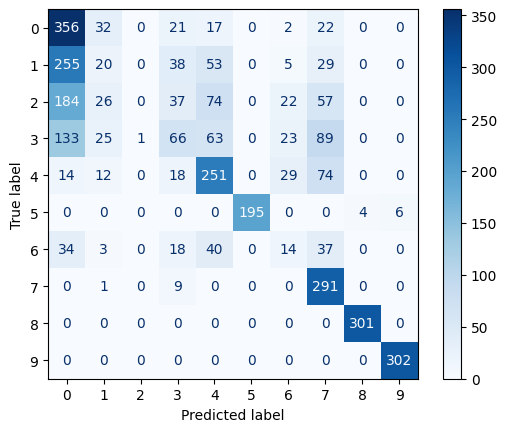

In [30]:
model_6.evaluate(X_test, y_test, X_train, y_train)

### 7. Seventh model - No Overfitting Prevention

To see if our overfitting techniques are actually working, we decided to create a model without any overfitting methods. We want to see if bias, batch normalization and dropout layers are actually working and improving our model.

Changes made compared to the first model:

- `bias`: from `True` to `False`
- `batch_normalization`: from `True` to `False`
- `dropout`: from `True` to `False`

In [31]:
layers_7 = [
    
    {'activation': 'sigmoid', 'size': 100, 'use_bias': False},
    {'activation': 'sigmoid', 'size': 100, 'use_bias': False},
    {'activation': 'sigmoid', 'size': 100, 'use_bias': False},
    {'activation': 'sigmoid', 'size': 100, 'use_bias': False},
]

model_7 = NeuralNetwork(layers_7, 'model_7')

In [32]:
model_7.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_7...
Epoch 1/30
929/929 [==============================] - 1s 1ms/step - loss: 2.2078 - accuracy: 0.1587 - val_loss: 2.1610 - val_accuracy: 0.1296
Epoch 2/30
929/929 [==============================] - 1s 1ms/step - loss: 2.0848 - accuracy: 0.2067 - val_loss: 2.0258 - val_accuracy: 0.2449
Epoch 3/30
929/929 [==============================] - 1s 1ms/step - loss: 1.9231 - accuracy: 0.2379 - val_loss: 1.8671 - val_accuracy: 0.2464
Epoch 4/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7646 - accuracy: 0.2695 - val_loss: 1.7328 - val_accuracy: 0.2776
Epoch 5/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6237 - accuracy: 0.2880 - val_loss: 1.6480 - val_accuracy: 0.2940
Epoch 6/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5621 - accuracy: 0.3041 - val_loss: 1.6008 - val_accuracy: 0.3333
Epoch 7/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5201 - accuracy: 0.3261 - val_loss: 1.5635 - val_acc

#### Evaluation

We got the worst accuracy so far of only 45%. We can also see that our training accuracy is lower and the testing accuracy is higher. In models before, the training and testing accuracies were either the same, or training was a bit higher. This means that we have overfitting in this model and using bias, batch normalization and dropout layers actually improved our model.

We can also observe something interesting: the accuracy for test in the line chart fluctuates more. This is likely due to the fact that we do not use dropout layers and batch normalization. This means that the model is not as stable as in the other models.

In our confusion matrix we can also observe way more false positives in general.

Test Loss: 1.3751, Test Accuracy: 45.35%
Train Loss: 1.3678, Train Accuracy: 44.89%


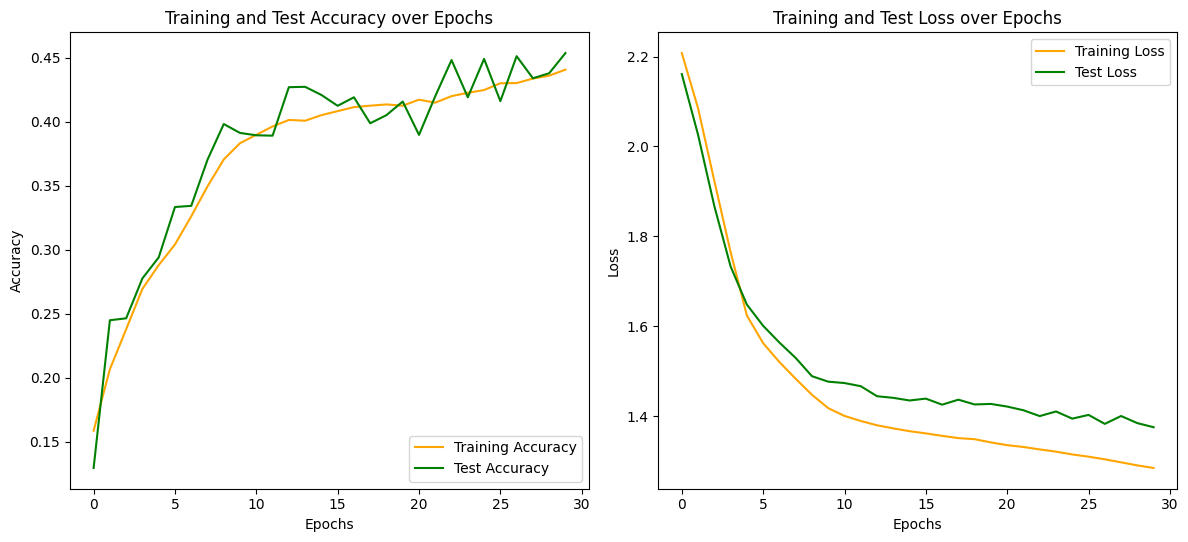

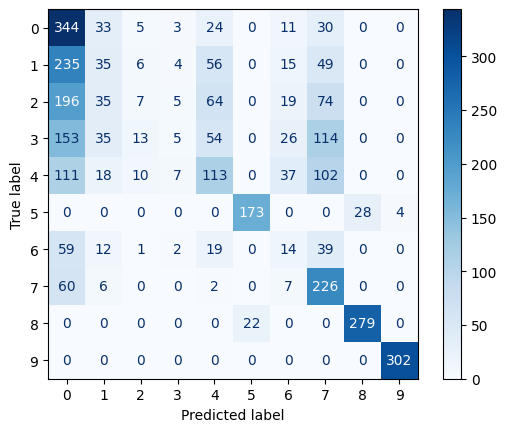

In [33]:
model_7.evaluate(X_test, y_test, X_train, y_train)

### 8. Eighth model - Using Regularization

As we have concluded in our researches described at the model structure creation, there are two regularization techniques:

- L1
- L2

L2 in general is better for accuracy, and L1 is more complex. We have decided to use L2, as it was described as the best for accuracy. For the size of the regularization, we have decided to use 1e-4 for L2 based on the default config written on the [Keras website](https://keras.io/api/layers/regularizers/).

Changes made compared to the first model:

- `regularization`: from `None` to `l2`

In [40]:
layers_8 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_8 = NeuralNetwork(layers_8, regularizer=tf.keras.regularizers.L2(l2=1e-4), name='model_8')

In [41]:
model_8.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5,  verbose=1)

Training model_8...
Epoch 1/30
929/929 [==============================] - 2s 1ms/step - loss: 2.0756 - accuracy: 0.2248 - val_loss: 1.6817 - val_accuracy: 0.3282
Epoch 2/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7689 - accuracy: 0.2685 - val_loss: 1.6133 - val_accuracy: 0.3424
Epoch 3/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6826 - accuracy: 0.2905 - val_loss: 1.5780 - val_accuracy: 0.3594
Epoch 4/30
929/929 [==============================] - 1s 1ms/step - loss: 1.6201 - accuracy: 0.3135 - val_loss: 1.5400 - val_accuracy: 0.3781
Epoch 5/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5739 - accuracy: 0.3319 - val_loss: 1.4950 - val_accuracy: 0.4111
Epoch 6/30
929/929 [==============================] - 1s 1ms/step - loss: 1.5332 - accuracy: 0.3546 - val_loss: 1.4571 - val_accuracy: 0.4317
Epoch 7/30
929/929 [==============================] - 1s 1ms/step - loss: 1.4999 - accuracy: 0.3707 - val_loss: 1.4320 - val_acc

#### Evaluation

With L2 regularization, we got a very similar accuracy of 54% as in model 1. What we can see compared to our initial model, is that the curve for the accuracy is less more smooth. The rest of the results are very similar to model 1.

Test Loss: 1.1762, Test Accuracy: 54.04%
Train Loss: 1.1663, Train Accuracy: 54.77%


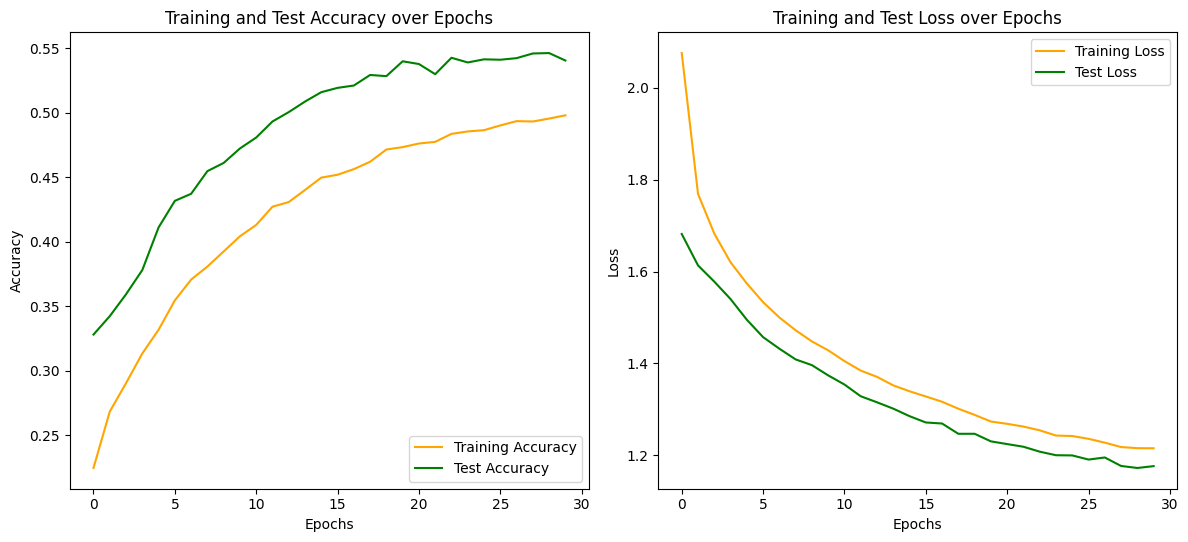

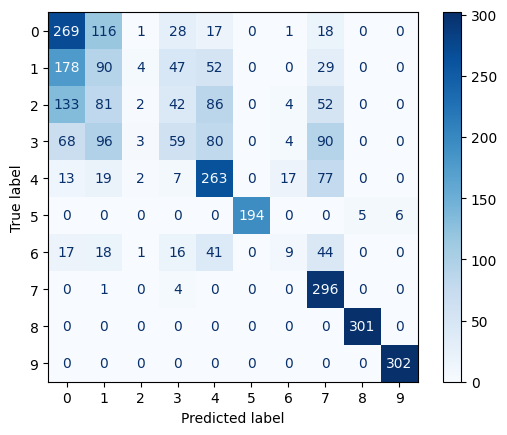

In [42]:
model_8.evaluate(X_test, y_test, X_train, y_train)

### 9. Ninth model - Researched Config

For our ninth model we conducted an online literature research to find the best combination for our model. We have found the following research paper in which they talk about our exact problem (poker cards):

<https://angeland.no/projects/codeshare/Poker_Hand_Induction__Multi_Class_Classification_of_Extreme_Imbalanced_Data_with_Machine_Learning.pdf>

The paper suggests using the following configuration:

- `layers`: 4
- `size`: 1024 neurons per layer
- `activation`: `relu`

We could not find much on bias, batch normalization, dropout layer and regularization, so we decided to configure them based on our own findings that resulted in the best results. In addition to the config presented in the research paper, we add L2 regularization as we saw it smoothens the accuracy curve making our model more stable. We also add bias and batch normalization as we saw that it improved our model in previous models. We also add dropout layers as we saw that it helps a lot to avoid overfitting.

Changes made compared to the first model:

- `layers`: from 3 to 4
- `size`: from 50 to 1024
- `regularization`: from `None` to `l2`

In [43]:
layers_9 = [
    {'activation': 'relu', 'size': 1024, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 1024, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 1024, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 1024, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_9 = NeuralNetwork(layers_9, regularizer=tf.keras.regularizers.L2(l2=1e-4), name='model_9')

In [44]:
model_9.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_9...
Epoch 1/30
929/929 [==============================] - 10s 10ms/step - loss: 2.5575 - accuracy: 0.3859 - val_loss: 1.9741 - val_accuracy: 0.4977
Epoch 2/30
929/929 [==============================] - 10s 11ms/step - loss: 1.9834 - accuracy: 0.4684 - val_loss: 1.7826 - val_accuracy: 0.5298
Epoch 3/30
929/929 [==============================] - 11s 11ms/step - loss: 1.8032 - accuracy: 0.4943 - val_loss: 1.7039 - val_accuracy: 0.5316
Epoch 4/30
929/929 [==============================] - 11s 12ms/step - loss: 1.6967 - accuracy: 0.5035 - val_loss: 1.6325 - val_accuracy: 0.5468
Epoch 5/30
929/929 [==============================] - 11s 12ms/step - loss: 1.6352 - accuracy: 0.5144 - val_loss: 1.6100 - val_accuracy: 0.5562
Epoch 6/30
929/929 [==============================] - 11s 11ms/step - loss: 1.5872 - accuracy: 0.5196 - val_loss: 1.5806 - val_accuracy: 0.5507
Epoch 7/30
929/929 [==============================] - 12s 12ms/step - loss: 1.5660 - accuracy: 0.5260 - val_loss: 1.

#### Evaluation

In this model we can see many changes compared to our previous models. First, the accuracy difference between training and testing is larger, almost 5% (this is the largest so far). This means that our model is likely overfittitng due to the large network size. However, we got the highest accuracy so far for both training and testing. Likely, the overfitting happens due to our over- and undersampling techniques. Interestingly, the test accuracy fluctuates more than in previous models. This is likely due to the fact that we have a larger network size. However, the train accuracy is very stable.

An other interesting observation is that the loss for training is stable and decreasing more but the test loss suddenly increases after 10 epochs.

When we look at the confusion matrix, we can also see a change. We have less false positives overall. The model could almost never guess label 6. Now it is way better at it. We can also see now way better the side effects of our dataset rebalancing techniques. We were undersampling the first four labels. We can clearly see a cluster of false positives for them. This is because they have no duplicates and they are all different. We can also see a massive cluster of true positives for the last three labels. This is because we were duplicating them.

Test Loss: 1.9828, Test Accuracy: 58.67%
Train Loss: 1.5831, Train Accuracy: 63.31%


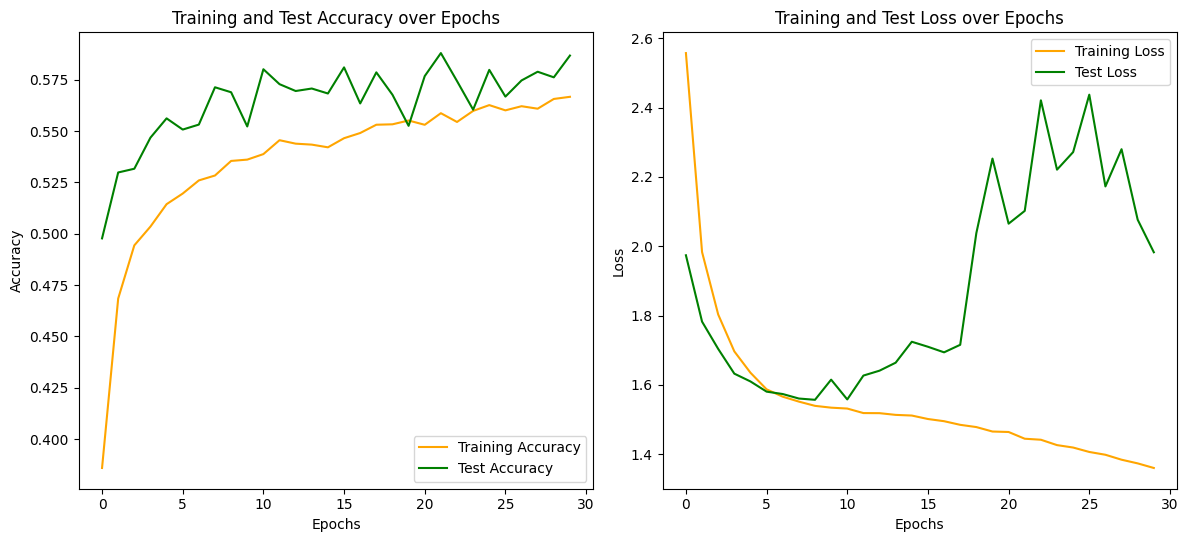

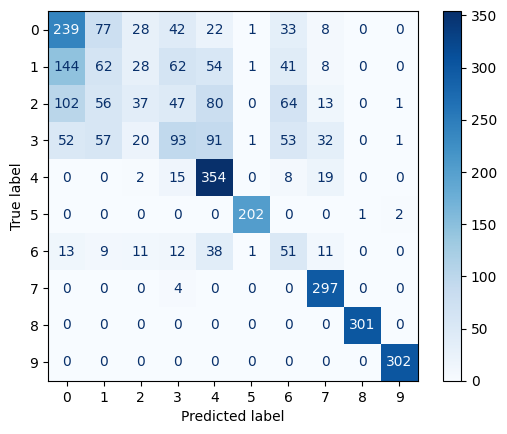

In [45]:
model_9.evaluate(X_test, y_test, X_train, y_train)

### 10. Tenth model - Different Optimizer

Since now, we always used Adam as our optimizer. Now we want to see if we can get better results with a different optimizer. We have decided to use SGD as it is an optimizer that Keras offers out of the box as a first option. So, we want to see if we can get better results with SGD. We recreate our first initial model but with SGD instead of Adam. Based on the [article](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) of Jason Brownlee, we decided to use 0.1 for the learning rate, 0.9 for momentum and 0.01 for decay as these are the best general values for SGD.

Changes made compared to the first model:

- `optimizer`: from `adam` to `sgd`

In [46]:
layers_10 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_10 = NeuralNetwork(layer_config=layers_10, name='model_10',optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=0.01))

In [47]:
model_10.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5,  verbose=1)

Training model_10...
Epoch 1/30
929/929 [==============================] - 1s 1ms/step - loss: 1.7118 - accuracy: 0.2771 - val_loss: 1.5497 - val_accuracy: 0.3333
Epoch 2/30
929/929 [==============================] - 1s 830us/step - loss: 1.5732 - accuracy: 0.3214 - val_loss: 1.4989 - val_accuracy: 0.3724
Epoch 3/30
929/929 [==============================] - 1s 820us/step - loss: 1.5425 - accuracy: 0.3326 - val_loss: 1.4875 - val_accuracy: 0.3890
Epoch 4/30
929/929 [==============================] - 1s 786us/step - loss: 1.5289 - accuracy: 0.3392 - val_loss: 1.4672 - val_accuracy: 0.4108
Epoch 5/30
929/929 [==============================] - 1s 783us/step - loss: 1.5144 - accuracy: 0.3491 - val_loss: 1.4602 - val_accuracy: 0.4114
Epoch 6/30
929/929 [==============================] - 1s 779us/step - loss: 1.5013 - accuracy: 0.3521 - val_loss: 1.4443 - val_accuracy: 0.4223
Epoch 7/30
929/929 [==============================] - 1s 808us/step - loss: 1.4953 - accuracy: 0.3543 - val_loss: 1.4

#### Evaluation

We can see that we got a lower accuracy than model 1. When we look at the accuracy over epochs chart, we can also see, that the gap between training and testing is way larger. In general, we can conclude that SGD is not a good optimizer for our model and Adam is better.

The confusion matrix confirms this even more. There are way more false positives and less true positives.

Test Loss: 1.3567, Test Accuracy: 46.56%
Train Loss: 1.3534, Train Accuracy: 46.86%


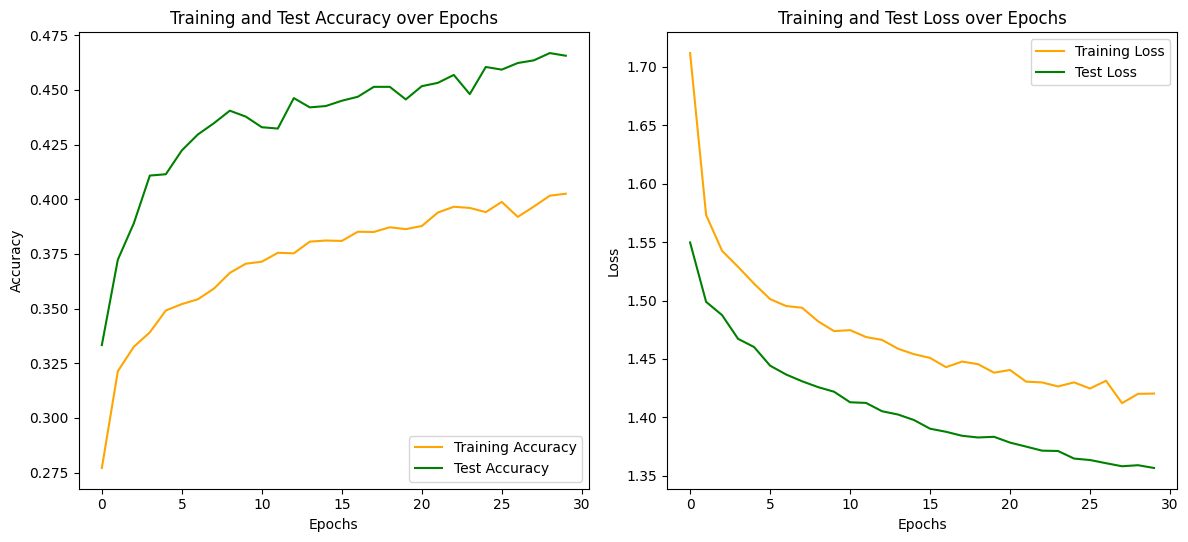

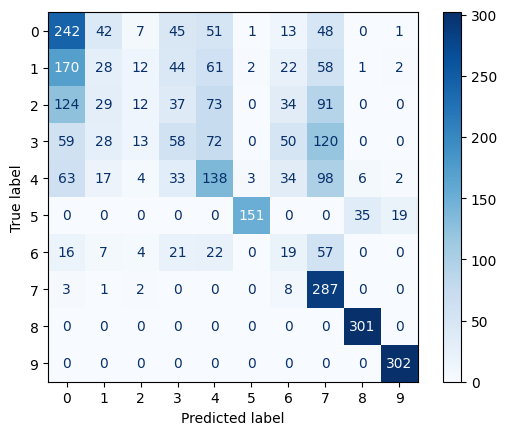

In [48]:
model_10.evaluate(X_test, y_test, X_train, y_train)

### 11. Eleventh model - Researched Config without Extra Techniques

We now want to recreate our ninth experiment, but this time using only the config mentioned in the research paper. This means, we only use configs that is mention. No batch normalization, bias, dropout layers and regularization.

Changes made compared to the first model:

- `layers`: from 3 to 4
- `size`: from 50 to 1024
- `bias`: from `True` to `False`
- `batch_normalization`: from `True` to `False`
- `dropout`: from `True` to `False`

In [49]:
layers_11 = [
    {'activation': 'relu', 'size': 1024, 'use_bias': False},
    {'activation': 'relu', 'size': 1024, 'use_bias': False},
    {'activation': 'relu', 'size': 1024, 'use_bias': False},
    {'activation': 'relu', 'size': 1024, 'use_bias': False},
]

model_11 = NeuralNetwork(layers_11, name='model_11')

In [50]:
model_11.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5,  verbose=1)

Training model_11...
Epoch 1/30
929/929 [==============================] - 7s 7ms/step - loss: 1.2308 - accuracy: 0.4627 - val_loss: 1.0742 - val_accuracy: 0.5783
Epoch 2/30
929/929 [==============================] - 7s 7ms/step - loss: 0.9339 - accuracy: 0.5773 - val_loss: 0.9943 - val_accuracy: 0.5849
Epoch 3/30
929/929 [==============================] - 6s 7ms/step - loss: 0.7930 - accuracy: 0.6344 - val_loss: 0.8939 - val_accuracy: 0.6403
Epoch 4/30
929/929 [==============================] - 7s 8ms/step - loss: 0.6807 - accuracy: 0.6817 - val_loss: 0.7897 - val_accuracy: 0.6770
Epoch 5/30
929/929 [==============================] - 7s 7ms/step - loss: 0.5906 - accuracy: 0.7172 - val_loss: 0.7390 - val_accuracy: 0.7003
Epoch 6/30
929/929 [==============================] - 7s 8ms/step - loss: 0.5216 - accuracy: 0.7493 - val_loss: 0.6803 - val_accuracy: 0.7193
Epoch 7/30
929/929 [==============================] - 7s 7ms/step - loss: 0.4610 - accuracy: 0.7754 - val_loss: 0.7208 - val_ac

#### Evaluation

We can see a massive jump in both training and testing accuracy. We got a whopping 97% accuracy on training and 81% accuracy on testing. Comparing to the other model where we also used overfitting prevention techniques, we got worse results (58% for test, 63% for training). We likely got this massive accuracy due to the fact that we have a large network size and we do not do any overfitting prevention techniques, so the model could remember the data.

With the massive difference between training and testing accuracy, we can conclude that we have massive overfitting. This proves the importance of overfitting prevention techniques. Interestingly, however, we still got a large overall improvement compared to the (same) previous model but with overfitting prevention techniques. Without dropout we use now more neurons and that means we can memorize more data. This is likely why we got a better result.

We also noticed, that for testing, the model's performance starts to degrade after 15 epochs.

When we look at the confusion matrix, we can see that we have way less false positives. Overall, this model showed us the best results in a confusion matrix. Between labels 0 and 3, we can still see a bit of false positive clusters. This is the side effect of us undersampling those labels. With the oversampled labels, from 7 to 9, we can see basically only true positives. This is because we duplicated those labels for oversampling.

Test Loss: 0.8102, Test Accuracy: 81.14%
Train Loss: 0.0803, Train Accuracy: 97.64%


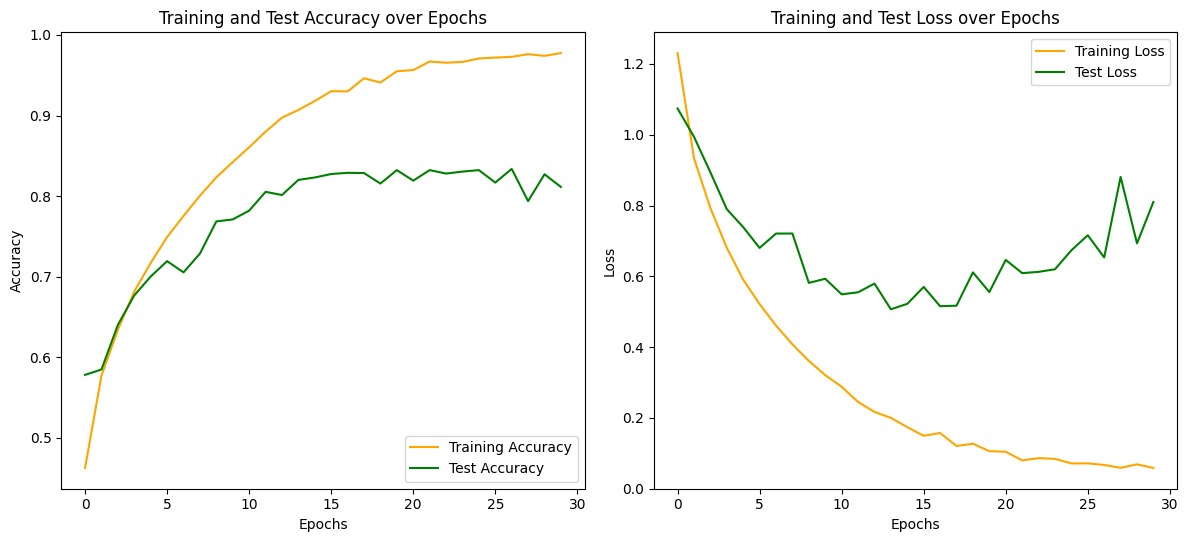

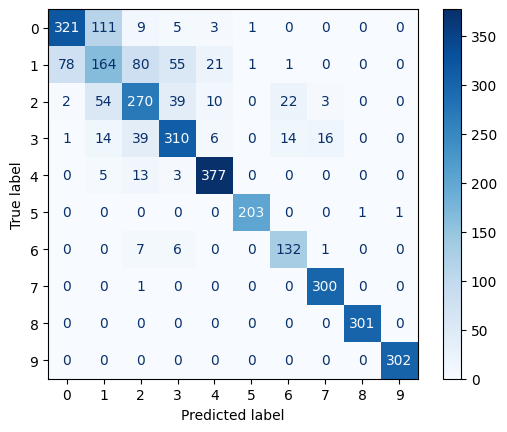

In [51]:
model_11.evaluate(X_test, y_test, X_train, y_train)

### 12. Twelfth model - No Dataset Balancing

In our previous models, we always balanced our dataset with both under- and oversampling. We also added class weights so we get a true accuracy. In the confusion matrixes, we always saw the side effects of our dataset balancing techniques. We saw clusters of false positives for labels we undersampled and did not duplicate, and we saw that the model performed way better on labels where we oversampled and duplicated.

Now we want to see what happens if we DO NOT use undersampling, oversampling, and class weights.

Changes made compared to the first model:

- NONE
- No undersampling
- No oversampling
- No class weights

In [52]:
# read in the dataset again
df_training = pd.read_csv('poker_hands.csv', sep=',', header=0)

# encode the dataset
df_suits = pd.get_dummies(df_training[['suit1', 'suit2', 'suit3', 'suit4', 'suit5']], prefix='suit')
df_training_encoded = pd.concat([df_training, df_suits], axis=1)
df_training_encoded = df_training_encoded.drop(['suit1', 'suit2', 'suit3', 'suit4', 'suit5'], axis=1)
label_encoder = {'nothing': 0, 'one_pair': 1, 'two_pairs': 2, 'three_of_a_kind': 3, 'straight': 4, 'flush': 5, 'full_house': 6, 'four_of_a_kind': 7, 'straight_flush': 8, 'royal_flush': 9}
df_training_encoded['ranking'] = df_training_encoded['ranking'].map(label_encoder)
df_training_encoded = df_training_encoded.astype('float32')

# create training and testing datasets
X = df_training_encoded.drop('ranking', axis=1) # values
y = df_training_encoded['ranking'] # labels
y_one_hot = tf.keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.1, random_state = 42, stratify=y)

In [53]:
layers_12 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_12 = NeuralNetwork(layers_12, 'model_12')

In [54]:
model_12.fit(X_train, y_train, X_test, y_test, epochs=30, weights=None, early_stopping_patience=5, verbose=1)

Training model_12...
Epoch 1/30
28829/28829 [==============================] - 29s 1ms/step - loss: 0.9841 - accuracy: 0.5227 - val_loss: 0.9338 - val_accuracy: 0.5498
Epoch 2/30
28829/28829 [==============================] - 29s 1ms/step - loss: 0.9490 - accuracy: 0.5408 - val_loss: 0.9286 - val_accuracy: 0.5509
Epoch 3/30
28829/28829 [==============================] - 28s 983us/step - loss: 0.9423 - accuracy: 0.5428 - val_loss: 0.9228 - val_accuracy: 0.5550
Epoch 4/30
28829/28829 [==============================] - 30s 1ms/step - loss: 0.9355 - accuracy: 0.5467 - val_loss: 0.9135 - val_accuracy: 0.5587
Epoch 5/30
28829/28829 [==============================] - 30s 1ms/step - loss: 0.9263 - accuracy: 0.5552 - val_loss: 0.8996 - val_accuracy: 0.5711
Epoch 6/30
28829/28829 [==============================] - 28s 987us/step - loss: 0.9135 - accuracy: 0.5650 - val_loss: 0.8989 - val_accuracy: 0.5689
Epoch 7/30
28829/28829 [==============================] - 29s 998us/step - loss: 0.9078 - acc

#### Evaluation

From the results, we can clearly see that our initial hypothesis, that we need dataset rebalancing, is now confirmed. After 15 epochs, the model lost its ability to learn and the difference between training and testing started to drastically change.

From the confusion matrix, we can observe the same. Basically, the model things everything is a `nothing` hand. Yes, our accuracy is good, around 50%, but the model just kept guessing the most common item, `nothing` and it was often right.

Test Loss: 0.9546, Test Accuracy: 53.99%
Train Loss: 0.9550, Train Accuracy: 53.98%


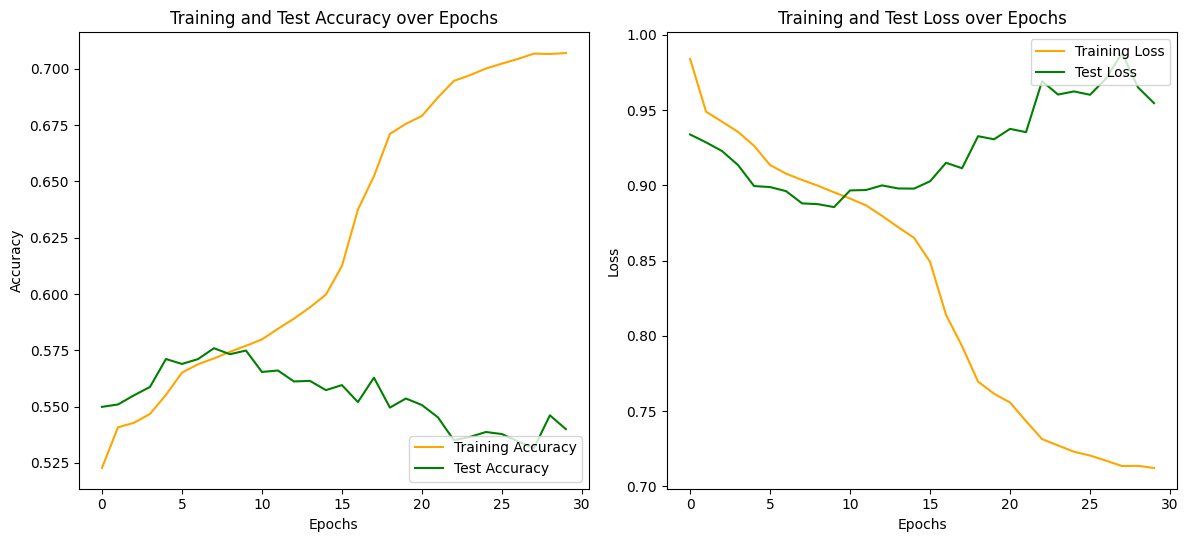

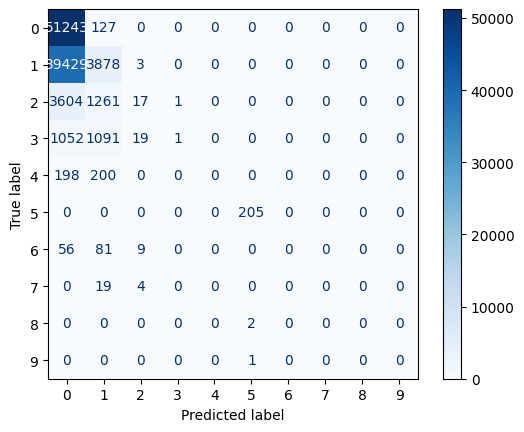

In [55]:
model_12.evaluate(X_test, y_test, X_train, y_train)

### 13. Thirteenth model - Only Class Weights

Now that we know how our model performs with no balancing (as we saw in model 12), we want to see what happens if we only add class weights for true accuracy and do no over and undersampling. With this we want to see what results we would get if we don't make duplicates with oversampling.

Changes made compared to the first model:

- NONE
- No undersampling
- No oversampling

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.1, random_state = 42, stratify=y)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 0.19953397105714987,
 1: 0.23666984532333404,
 2: 2.099225854018186,
 3: 4.737958768604973,
 4: 25.766968325791854,
 5: 50.00048780487805,
 6: 70.20616438356164,
 7: 434.3262711864407,
 8: 6029.470588235294,
 9: 12812.625}

In [57]:
layers_13 = [
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
    {'activation': 'relu', 'size': 50, 'use_bias': True, 'dropout': 0.25, 'batch_norm': True},
]

model_13 = NeuralNetwork(layers_13, 'model_13')

In [58]:
model_13.fit(X_train, y_train, X_test, y_test, epochs=30, weights=class_weights_dict, early_stopping_patience=5, verbose=1)

Training model_13...
Epoch 1/30
28829/28829 [==============================] - 31s 1ms/step - loss: 2.4122 - accuracy: 0.0961 - val_loss: 2.1696 - val_accuracy: 0.0604
Epoch 2/30
28829/28829 [==============================] - 32s 1ms/step - loss: 2.2419 - accuracy: 0.1011 - val_loss: 2.0633 - val_accuracy: 0.0686
Epoch 3/30
28829/28829 [==============================] - 31s 1ms/step - loss: 2.2096 - accuracy: 0.1155 - val_loss: 2.0869 - val_accuracy: 0.0797
Epoch 4/30
28829/28829 [==============================] - 31s 1ms/step - loss: 2.2137 - accuracy: 0.1230 - val_loss: 2.0173 - val_accuracy: 0.0845
Epoch 5/30
28829/28829 [==============================] - 31s 1ms/step - loss: 2.2221 - accuracy: 0.1269 - val_loss: 1.9819 - val_accuracy: 0.1043
Epoch 6/30
28829/28829 [==============================] - 30s 1ms/step - loss: 2.0832 - accuracy: 0.1404 - val_loss: 1.9727 - val_accuracy: 0.1806
Epoch 7/30
28829/28829 [==============================] - 30s 1ms/step - loss: 2.2852 - accuracy:

#### Evaluation

Now with class weights, we can finally see our model with a true accuracy without any over- and undersampling. With an accuracy of 22%, we can prove that our model is clueless. When we look at the confusion matrix, we can see that now it actually tried to guess other labels than a 0 due to the class weights, but it was just randomly guessing. Our model is not confident at all, and is still biased towards the samples with a large amount of data.

In our graphs, we can see big spikes with massive fluctuations. This is yet an other evidence that our model is not confident at all. However, we get the same difference between test and train accuracy as with out initial model. This means that our model, just like the initial one, is not overfitting.

This test concludes that we our approach to over- and undersampling is necessary.

Test Loss: 1.8478, Test Accuracy: 24.47%
Train Loss: 1.8483, Train Accuracy: 24.41%


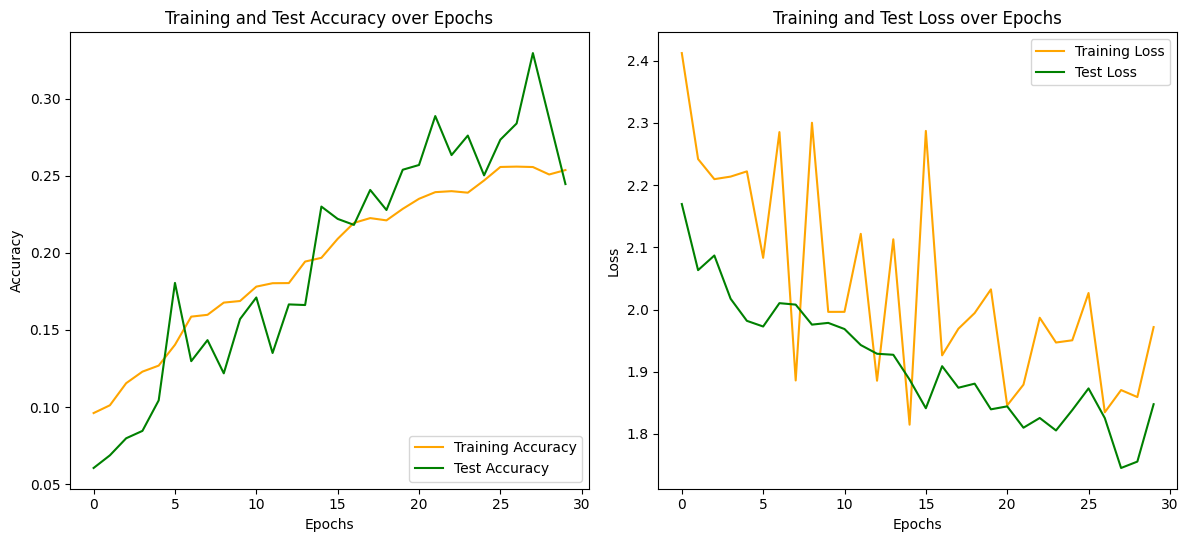

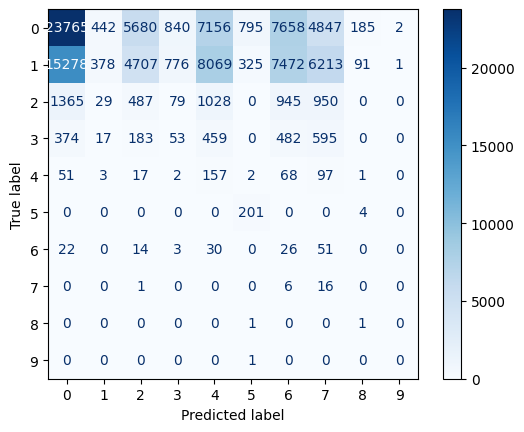

In [59]:
model_13.evaluate(X_test, y_test, X_train, y_train)

## Best model

From our experiments, we got the overall highest accuracy on testing for model 11.

Given a CSV file with poker hands, the model can show it's accuracy.

**Important Note:** Due to the nature of the `get_dummies` function, all combinations of the suits must be present for each suit slot. With only 1 line of data, the encoding will not work as it will only fill in `True` for every suit. Make sure to have enough samples!

In [40]:
test_file = 'poker_hands_test.csv' # test file

# load keras model
best_model = tf.keras.models.load_model('./best-models/as2.1.keras')
# initialize predictor
predictor = NeuralNetwork(None, None, model=best_model)
# predict with accuracy
predictor.predict(test_file)

Test Loss: 0.1850, Test Accuracy: 94.12%
